In [32]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml
import time

import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
seed(20)
randSeed = np.random.randint(1000)

# === gather variables provided as input arguments ===
config_file = 'config.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
ChSh_Coeff_file = config['ChSh_Coeff_file']
input_variables = config['input_variables']
train_dates_range = config['train_dates_range']
train_locations = config['train_locations']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
n_d = config['n_d']
n_steps = config['n_steps']
n_independent = config['n_independent']
n_shared = config['n_shared']
nTrial = config['nTrial']
nEns = config['nEns']
feature_importance = config['feature_importance']
number_of_features = config['number_of_features']
experiment = config['experiment']

In [33]:
def featImp_variables(target_variable,number_of_features):
    # === Load important features ===#
    sorted_feature_importance_array = np.load(f'Coefficient_{target_variable}_featImp.npy')    
    # Access the data from the numpy array
    feature_names = sorted_feature_importance_array['Feature']
    importances = sorted_feature_importance_array['Importance']
    return feature_names[:number_of_features[target_variable]]

In [34]:
def data_processing(input_file,ChSh_Coeff_file,input_variables,target_variables, dates_range, locations,val_arg=None):
    inputs = xr.open_dataset(input_file)
    ChSh_Coeff = xr.open_dataset(ChSh_Coeff_file)

    if val_arg:
        #=== Extracting training and validation indices ===# 
        time_coord = inputs.sel(time=slice(*dates_range)).coords['time']
        years = time_coord.dt.year
        months = time_coord.dt.month
        validation_times = np.zeros(len(time_coord), dtype=bool)
        for year in np.unique(years):
            for month in range(1, 13):
                month_indices = np.where((years == year) & (months == month))[0]
                if len(month_indices) >= int(6*24/input_times_freq):
                    start_index = np.random.choice(len(month_indices) - int(6*24/input_times_freq) - 1)
                    validation_indices = month_indices[start_index:start_index + int(6*24/input_times_freq)]
                    validation_times[validation_indices] = True
        
        #=== Finish Extracting training and validation indices ===# 
        X_train = np.empty((0, len(input_variables)))
        Y_train = np.empty((0, len(target_variables)))
        X_valid = np.empty((0, len(input_variables)))
        Y_valid = np.empty((0, len(target_variables)))
    
        for loc in locations:
            # --- training ---#
            X_loc = inputs[input_variables].sel(time=slice(*dates_range)).sel(time=~validation_times, location=loc).to_array().values.T
            X_train = np.concatenate((X_train, X_loc), axis=0)
            Y_loc = ChSh_Coeff.sel(time=slice(*dates_range,input_times_freq)).sel(coeff=target_variables,time=~validation_times, obs=loc).to_array().values
            Y_train = np.concatenate((Y_train, Y_loc[0,:,:]), axis=0)
    
            # --- vlaidation ---#
            X_loc = inputs[input_variables].sel(time=slice(*dates_range)).sel(time=validation_times, location=loc).to_array().values.T
            X_valid = np.concatenate((X_valid, X_loc), axis=0)
            Y_loc = ChSh_Coeff.sel(time=slice(*dates_range,input_times_freq)).sel(coeff=target_variables,time=validation_times, obs=loc).to_array().values
            Y_valid = np.concatenate((Y_valid, Y_loc[0,:,:]), axis=0)        
    
        # Replace NaN values with zeros
        X_train = np.nan_to_num(X_train)
        Y_train = np.nan_to_num(Y_train)
        X_valid = np.nan_to_num(X_valid)
        Y_valid = np.nan_to_num(Y_valid)
        
        return X_train, Y_train, X_valid, Y_valid

    else:
        X = np.empty((0, len(input_variables)))
        Y = np.empty((0, len(target_variables)))

        for loc in locations:
            # --- testing ---#
            X_loc = inputs[input_variables].sel(time=slice(*dates_range)).sel(location=loc).to_array().values.T
            X = np.concatenate((X, X_loc), axis=0)
            Y_loc = ChSh_Coeff.sel(time=slice(*dates_range,input_times_freq)).sel(coeff=target_variables, obs=loc).to_array().values
            Y = np.concatenate((Y, Y_loc[0,:,:]), axis=0)

        # Replace NaN values with zeros
        X = np.nan_to_num(X)
        Y = np.nan_to_num(Y)

        return X, Y

In [35]:
# === training and validation data parameters ===#
target_variables = [0,1,2,3,4]
X_train,Y_train, X_valid,Y_valid = data_processing(input_file,ChSh_Coeff_file,input_variables,target_variables,train_dates_range,train_locations,val_arg=True)
print('training inputs shape:',X_train.shape,'training targets shape:',Y_train.shape,'validation inputs shape:',X_valid.shape,'validation targets shape:',Y_valid.shape)

training inputs shape: (7056, 34) training targets shape: (7056, 5) validation inputs shape: (1728, 34) validation targets shape: (1728, 5)


In [36]:
# === testing data parameters ===#
target_variables = [0,1,2,3,4]
X_test,Y_test = data_processing(input_file,ChSh_Coeff_file,input_variables,target_variables,test_dates_range,test_locations)
print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)

testing inputs shape: (8760, 34) testing targets shape: (8760, 5)


In [27]:
def hexbin_plotter(gs,Y,pred,title,text_arg=None,xlabel_arg=None,ylabel_arg=None):
    errMAE    = mae(Y,pred)
    errRMSE   = np.sqrt(mse(Y,pred))
    errMAPE   = mape(Y,pred)
    errR2     = R2(Y,pred)

    ax_hexbin = fig.add_subplot(gs)
    hb = ax_hexbin.hexbin(np.squeeze(Y), np.squeeze(pred), gridsize=100, bins='log', cmap='inferno')
    if text_arg:
        ax_hexbin.text(0.05, 0.93, f'MAE: {errMAE:.2f} \n$R^2$: {errR2:.2f}\nRMSE: {errRMSE:.2f} \nMAPE: {errMAPE:.2f}',
                      transform=ax_hexbin.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    if xlabel_arg:
        ax_hexbin.set_xlabel(f'observed coefficient')
    if ylabel_arg:
        ax_hexbin.set_ylabel(f'Predicted coefficient')
    ax_hexbin.set_title(f'{title}')

    min_value = Y.min()
    max_value = Y.max()
    ax_hexbin.set_xlim(min_value, max_value)
    ax_hexbin.set_ylim(min_value, max_value)

In [28]:
nELI5max = 1 #FIXME
def myELI5(model,X,y,multiout=None,target_variable=None):
    
    nSamples, nFeatures = np.shape(X)
    iTot = np.arange(0,nSamples,1)
    
    #Original prediction
    if multiout:
        y_pred_org = model.predict(X)[:,target_variable]
    else:
        y_pred_org = model.predict(X)
    E_org      = np.sqrt(mse(y,y_pred_org)) 
    
    featImp = np.zeros(nFeatures)
    for nF in range(nFeatures):

        E_shfl_tot = 0
        for nELI5 in range(nELI5max):
            
            X_shfl = np.copy(X)

            np.random.shuffle(iTot)

            dum          = X_shfl[:,nF]
            X_shfl[:,nF] = dum[iTot]
            X_shfl       = pd.DataFrame(data=X_shfl)
            if multiout:
                y_pred_shfl  = model.predict(X_shfl.values)[:,target_variable]
            else:
                y_pred_shfl  = model.predict(X_shfl.values)
            E_shfl       = np.sqrt(mse(y,y_pred_shfl))

            E_shfl_tot   = E_shfl_tot + E_shfl

        #print(nF,E_org,E_shfl_tot/nELI5/E_org)
        featImp[nF] = (E_shfl_tot/nELI5max - E_org)*100/E_org
        
    return featImp

In [29]:
def feat_imp_plotter(gs,input_variables,featImp,title,color,xticklabels=None):
    ax = fig.add_subplot(gs)
    ax.bar(input_variables,featImp,color=color)
    ax.set_title(title)
    if xticklabels:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(input_variables,rotation='vertical')
    else:
        ax.set_xticklabels('')

In [ ]:
# === plotter for single output training ===#
fig = plt.figure(figsize=(15, 30), constrained_layout=True)
gs = fig.add_gridspec(10,5)
for Ens in range(10):
    for j,target_variable in enumerate(target_variables):
        '''
        if feature_importance[0]:
            input_variables = featImp_variables(target_variable)
        X_test,Y_test = data_processing(input_variables,[target_variable],test_dates_range,test_locations,test_arg=True)
        print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)        
        '''
        OUTPUT_DIR = f'models_{experiment}th_set/coefficient_{target_variable}/Ens_{Ens}'
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        # --- load normalizer ---#
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
            ylabel_arg = True if j == 0 else False
            xlabel_arg = True if Ens == 9 else False
            hexbin_plotter(gs[Ens,j],Y_test[:,target_variable],Y_pred[:,0],
                           f'Ens:{Ens},C{target_variable},[{tabReg.n_d},{tabReg.n_a},{tabReg.n_steps},{tabReg.n_independent},{tabReg.n_shared},{tabReg.gamma}]',
                           text_arg=True,xlabel_arg=xlabel_arg,ylabel_arg=ylabel_arg)         
plt.savefig(f'{experiment}th_set_ensemble_test.png')

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


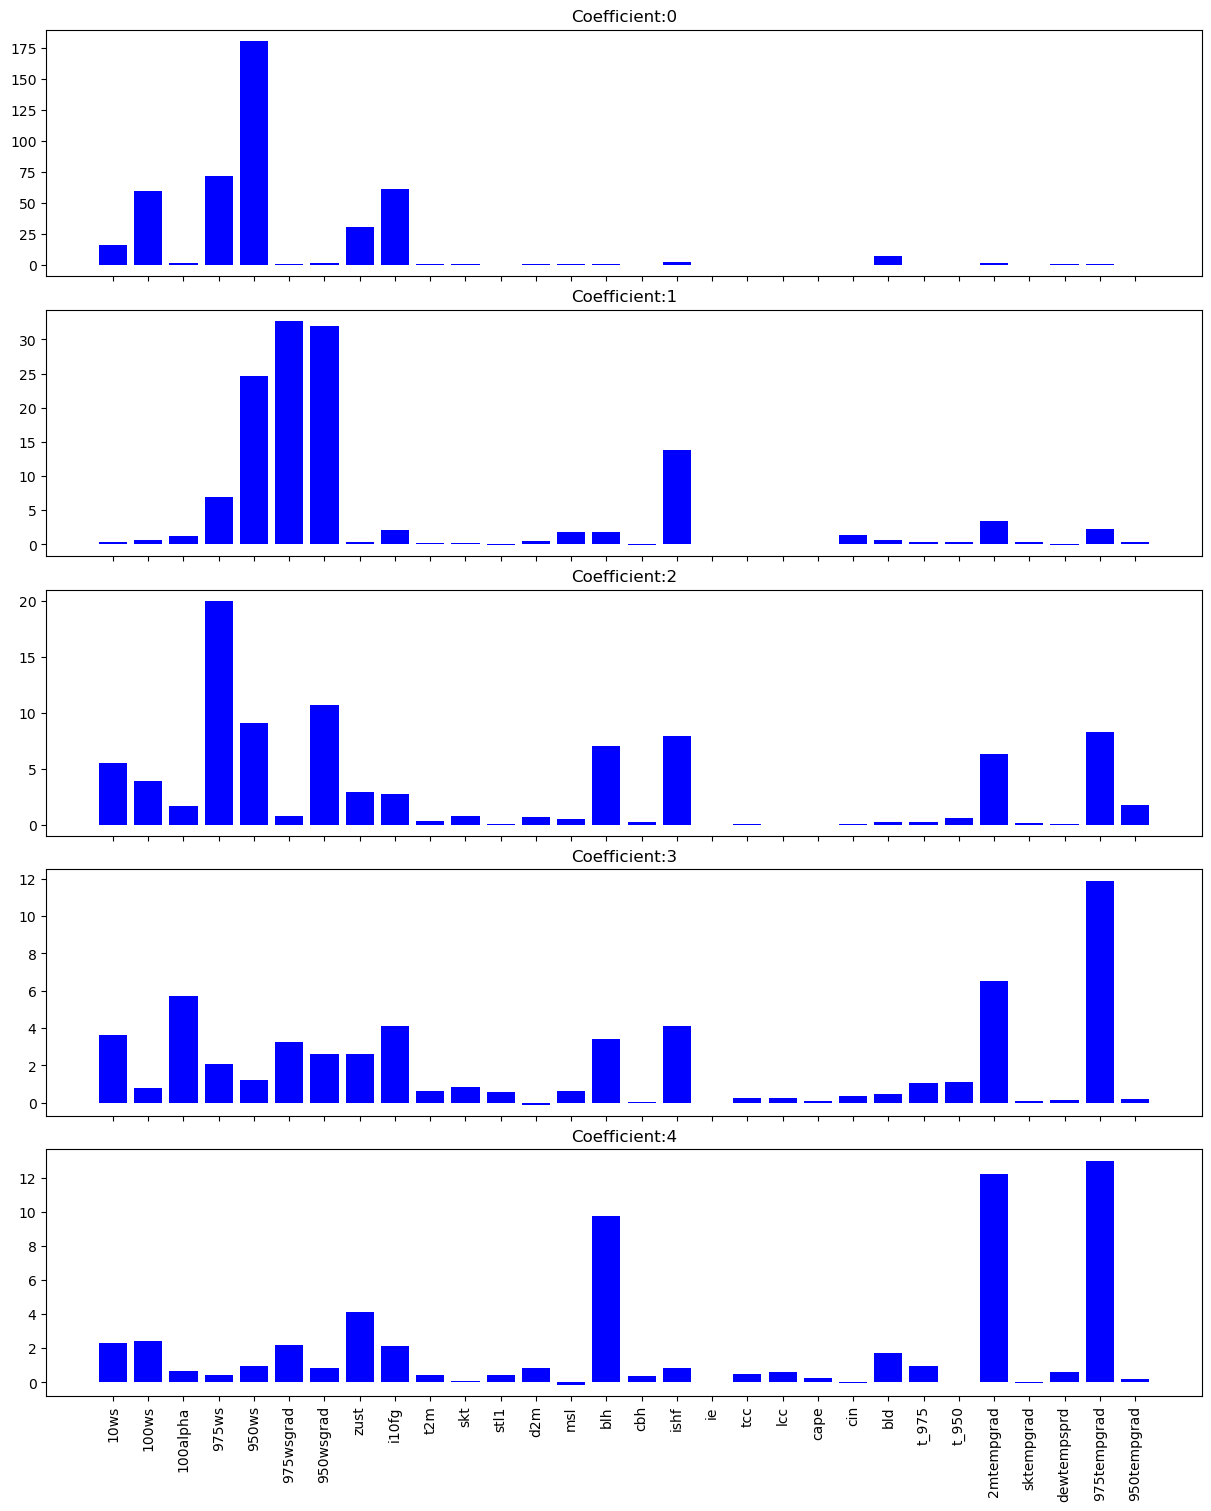

In [97]:
fig = plt.figure(figsize=(12,15), constrained_layout=True)
gs = fig.add_gridspec(5,1)
for j,target_variable in enumerate(target_variables):
    featImp = []
    for Ens in range(10):
        OUTPUT_DIR = f'models_6th_set/coefficient_{target_variable}/Ens_{Ens}'
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = tabReg.predict(X_test)
            Y_test[:,target_variable],Y_pred[:,0]
            # --- feat imp ---#
            featImp.append(myELI5(tabReg,X_test,Y_test[:,target_variable]))
        print(Ens)
    xticklabels = True if j == 4 else False
    feat_imp_plotter(gs[j],input_variables,np.array(featImp).mean(axis=0),f'Coefficient:{target_variable}','blue',xticklabels=xticklabels)
plt.savefig(f'6th_set_ensemble_testing_feature_importance.png')

In [43]:
Ens = 0
OUTPUT_DIR = f'trained_models/models_{experiment}th_set/Ens_{Ens}'
fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
with open(fSTR, "rb") as f:
    tabReg = pickle.load(f)
tabReg

TabNetRegressor(n_d=16, n_a=16, n_steps=3, gamma=1.1, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=1, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=931, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=14, output_dim=5, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)
testing inputs shape: (2928, 14) testing targets shape: (2928, 5)


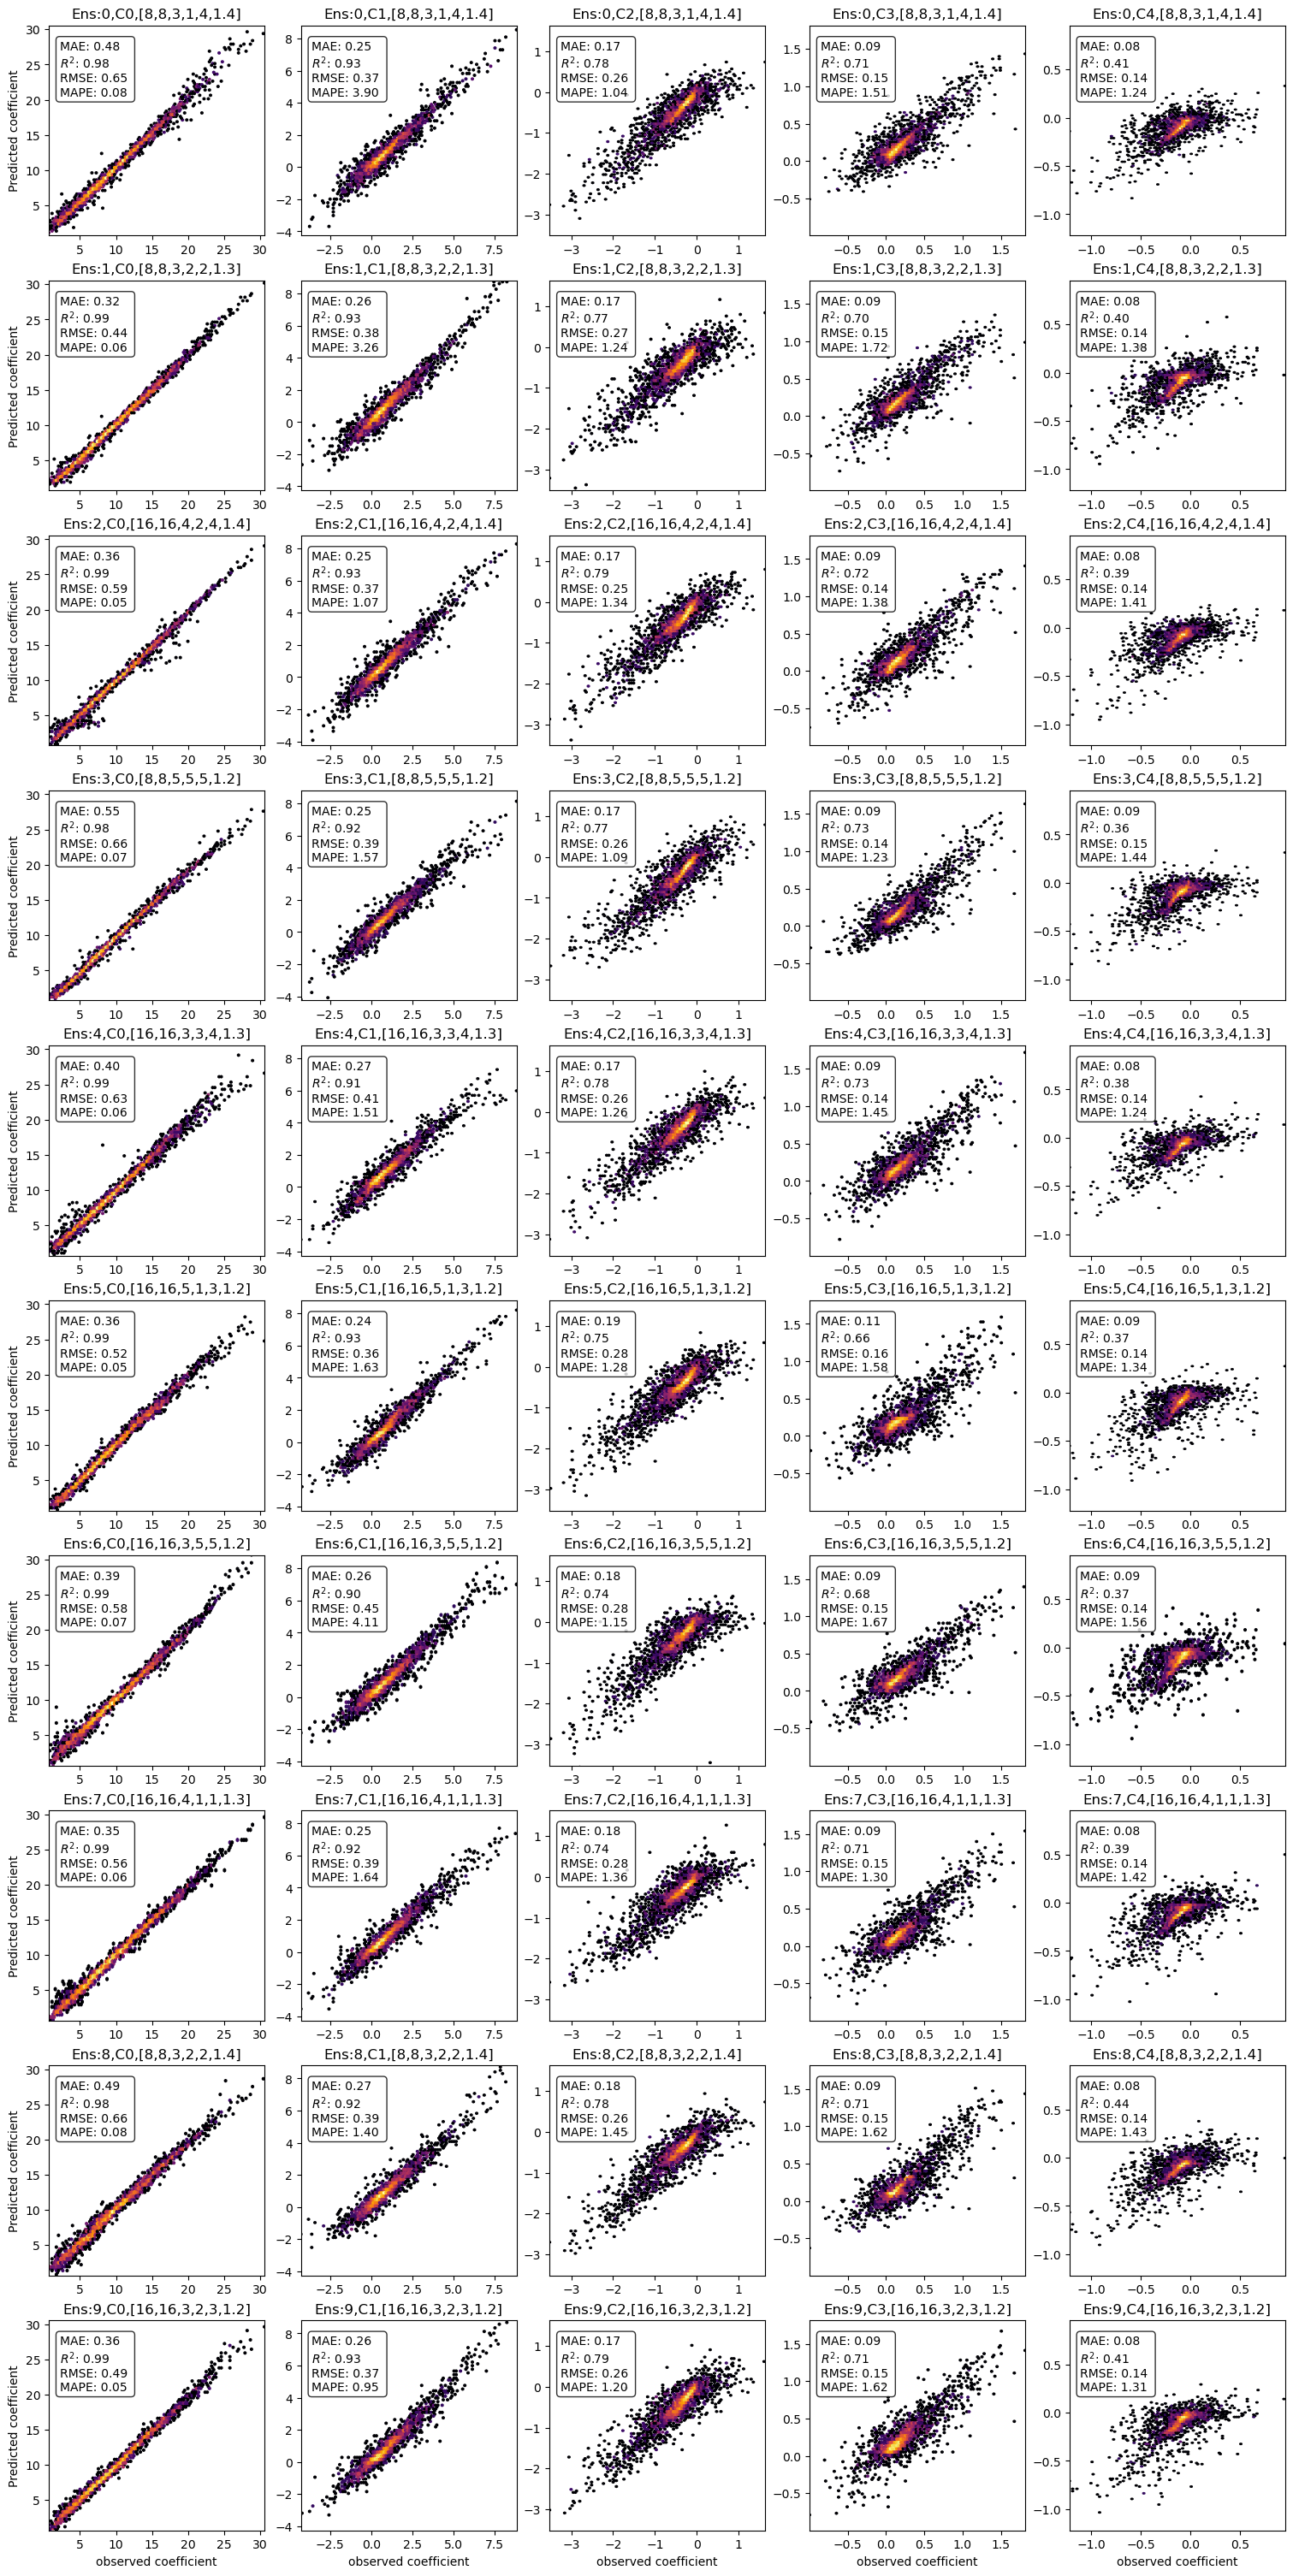

In [9]:
# === Plotter for multioutput training ===#
fig = plt.figure(figsize=(15, 30), constrained_layout=True)
gs = fig.add_gridspec(10,5)
featImp = []
for Ens in range(10):
    X_test,Y_test = data_processing(input_variables,target_variables,test_dates_range,test_locations)
    print('testing inputs shape:',X_test.shape,'testing targets shape:',Y_test.shape)            
    OUTPUT_DIR = f'models_{experiment}th_set/Ens_{Ens}'
    # --- load normalizer ---#
    min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')
    Y_test_trans = min_max_scaler.transform(Y_test)
    fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
    with open(fSTR, "rb") as f:
        tabReg = pickle.load(f)
        Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test))
        for j,target_variable in enumerate(target_variables):
            ylabel_arg = True if j == 0 else False
            xlabel_arg = True if Ens == 9 else False
            hexbin_plotter(gs[Ens,j],Y_test[:,target_variable],Y_pred[:,target_variable],
                           f'Ens:{Ens},C{target_variable},[{tabReg.n_d},{tabReg.n_a},{tabReg.n_steps},{tabReg.n_independent},{tabReg.n_shared},{tabReg.gamma}]',
                           text_arg=True,xlabel_arg=xlabel_arg,ylabel_arg=ylabel_arg)     
        # --- feat imp ---#
        featImp.append(myELI5(tabReg,X_test,Y_test_trans))
plt.savefig(f'{experiment}th_set_ensemble_test.png')

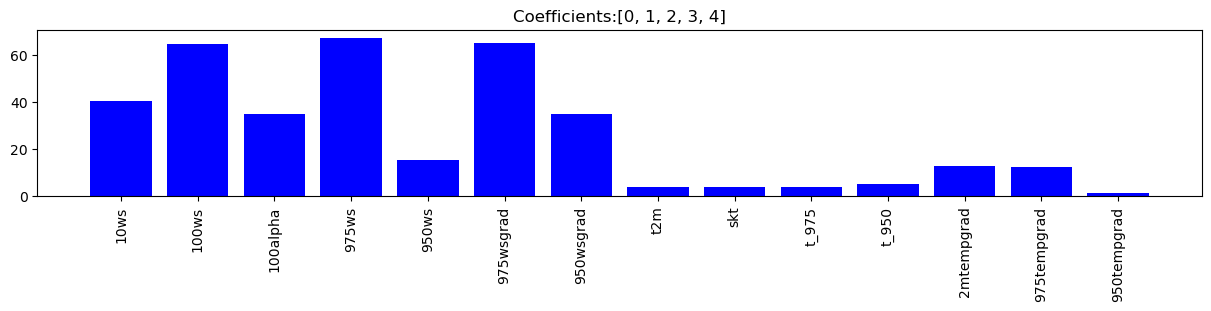

In [10]:
fig = plt.figure(figsize=(12,3), constrained_layout=True)
gs = fig.add_gridspec(1,1)
feat_imp_plotter(gs[0],input_variables,np.array(featImp).mean(axis=0),f'Coefficients:{target_variables}','blue',xticklabels=True)
plt.savefig(f'{experiment}th_set_ensemble_test_multi_output_feature_importance.png')

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


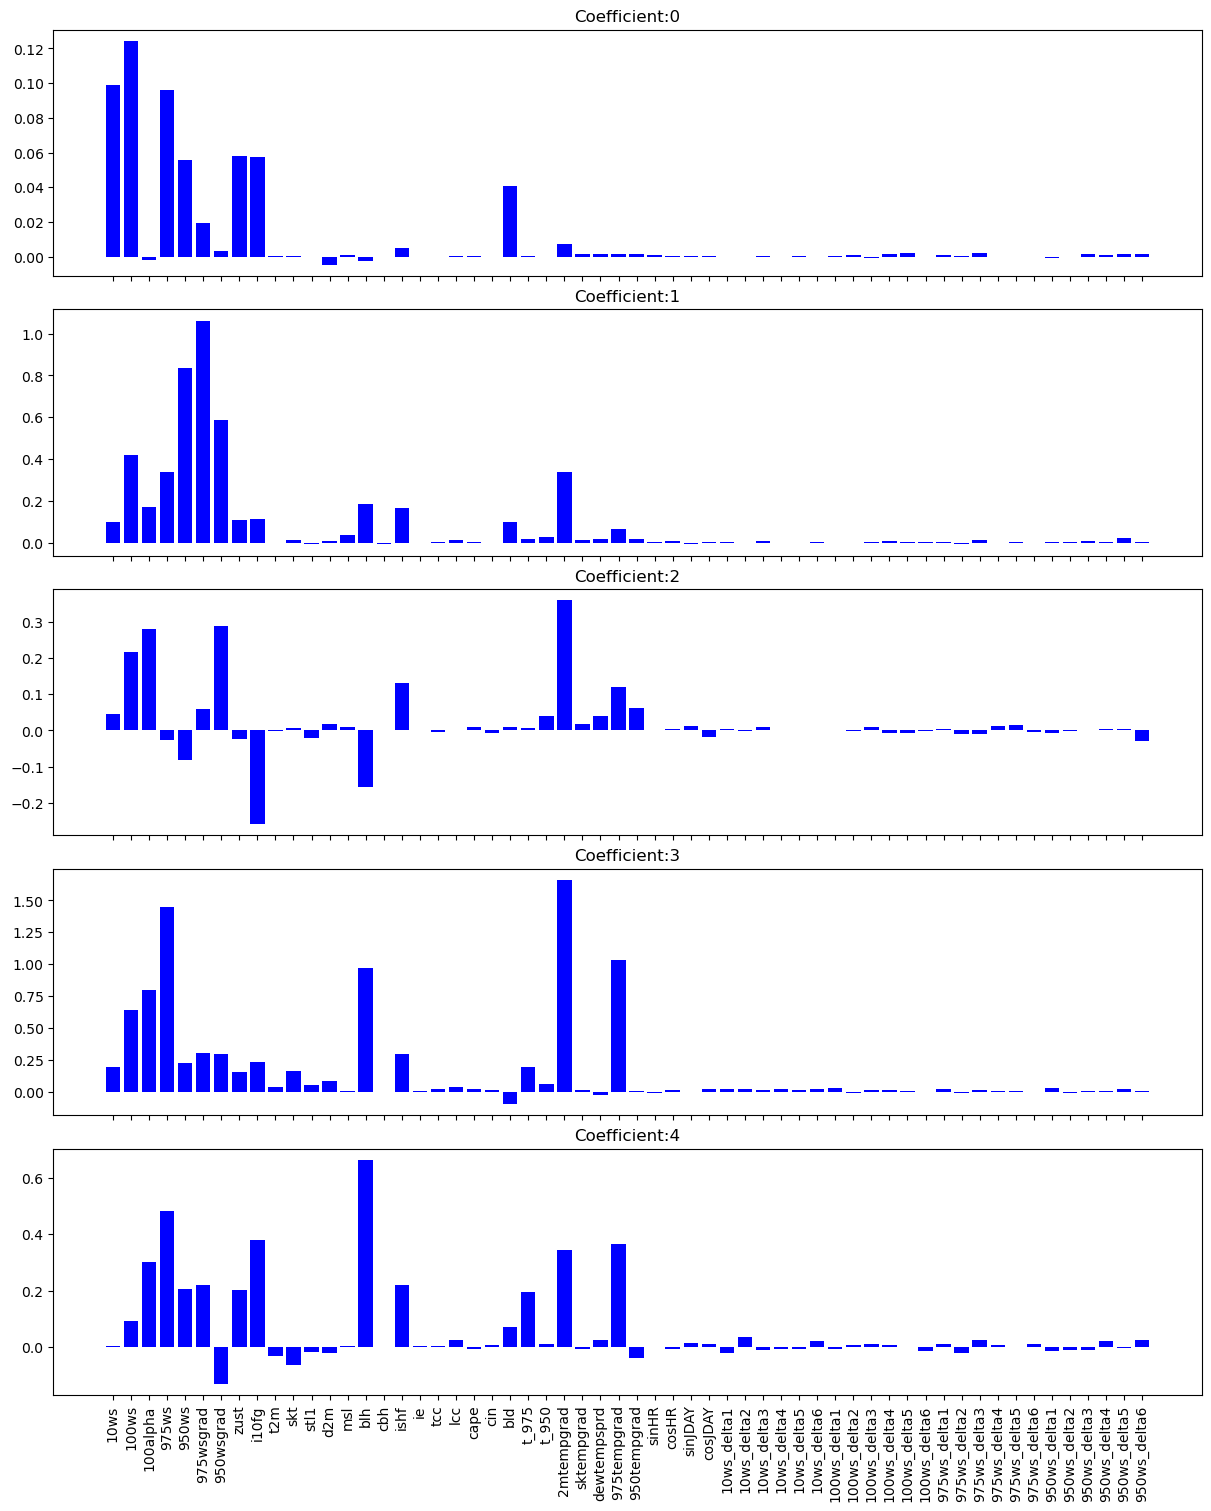

In [42]:
fig = plt.figure(figsize=(12,15), constrained_layout=True)
gs = fig.add_gridspec(5,1)
for j,target_variable in enumerate(target_variables):
    featImp = []
    for Ens in range(10):
        OUTPUT_DIR = f'models_{experiment}th_set/Ens_{Ens}'
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = tabReg.predict(X_test)
            Y_test[:,target_variable],Y_pred[:,target_variable]
            # --- feat imp ---#
            featImp.append(myELI5(tabReg,X_test,Y_test[:,target_variable],multiout=True,target_variable=target_variable))
        print(Ens)
    xticklabels = True if j == 4 else False
    feat_imp_plotter(gs[j],input_variables,np.array(featImp).mean(axis=0),f'Coefficient:{target_variable}','blue',xticklabels=xticklabels)
plt.savefig(f'{experiment}th_set_ensemble_test_multi_output_individual_feature_importance.png')

In [30]:
Z = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
poly_order = 4
CPtype = 1
from scipy.interpolate import interp1d
def normalize(H):
    a = 2 / (np.max(H) - np.min(H))
    b = - (np.max(H) + np.min(H)) / (np.max(H) - np.min(H))
    Hn = a * H + b
    return Hn
def Chebyshev_Basu(x, poly_order, CPtype):
    if x.ndim == 1:
        x = x[:, np.newaxis]

    CP = np.zeros((len(x), poly_order + 1))

    CP[:, 0] = 1  # T0(x) = 1
    if poly_order >= 1:
        if CPtype == 1:  # Chebyshev polynomial of first kind
            CP[:, 1] = x.flatten()  # T1(x) = x
        else:  # Chebyshev polynomial of second kind
            CP[:, 1] = 2 * x.flatten()  # U1(x) = 2x
        if poly_order >= 2:
            for n in range(2, poly_order + 1):
                CP[:, n] = 2 * x.flatten() * CP[:, n - 1] - CP[:, n - 2]
    return CP
def WindProfile(Z,Coeff):
    Hn = normalize(Z)
    PL_full = Chebyshev_Basu(Hn, poly_order, CPtype)
    Mp = PL_full @ Coeff
    return Mp

In [34]:
test_dates_range

['2004-01-01T00:00:00', '2004-12-31T23:00:00']

/tmp/ipykernel_3249440/2313155246.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 1, 1])


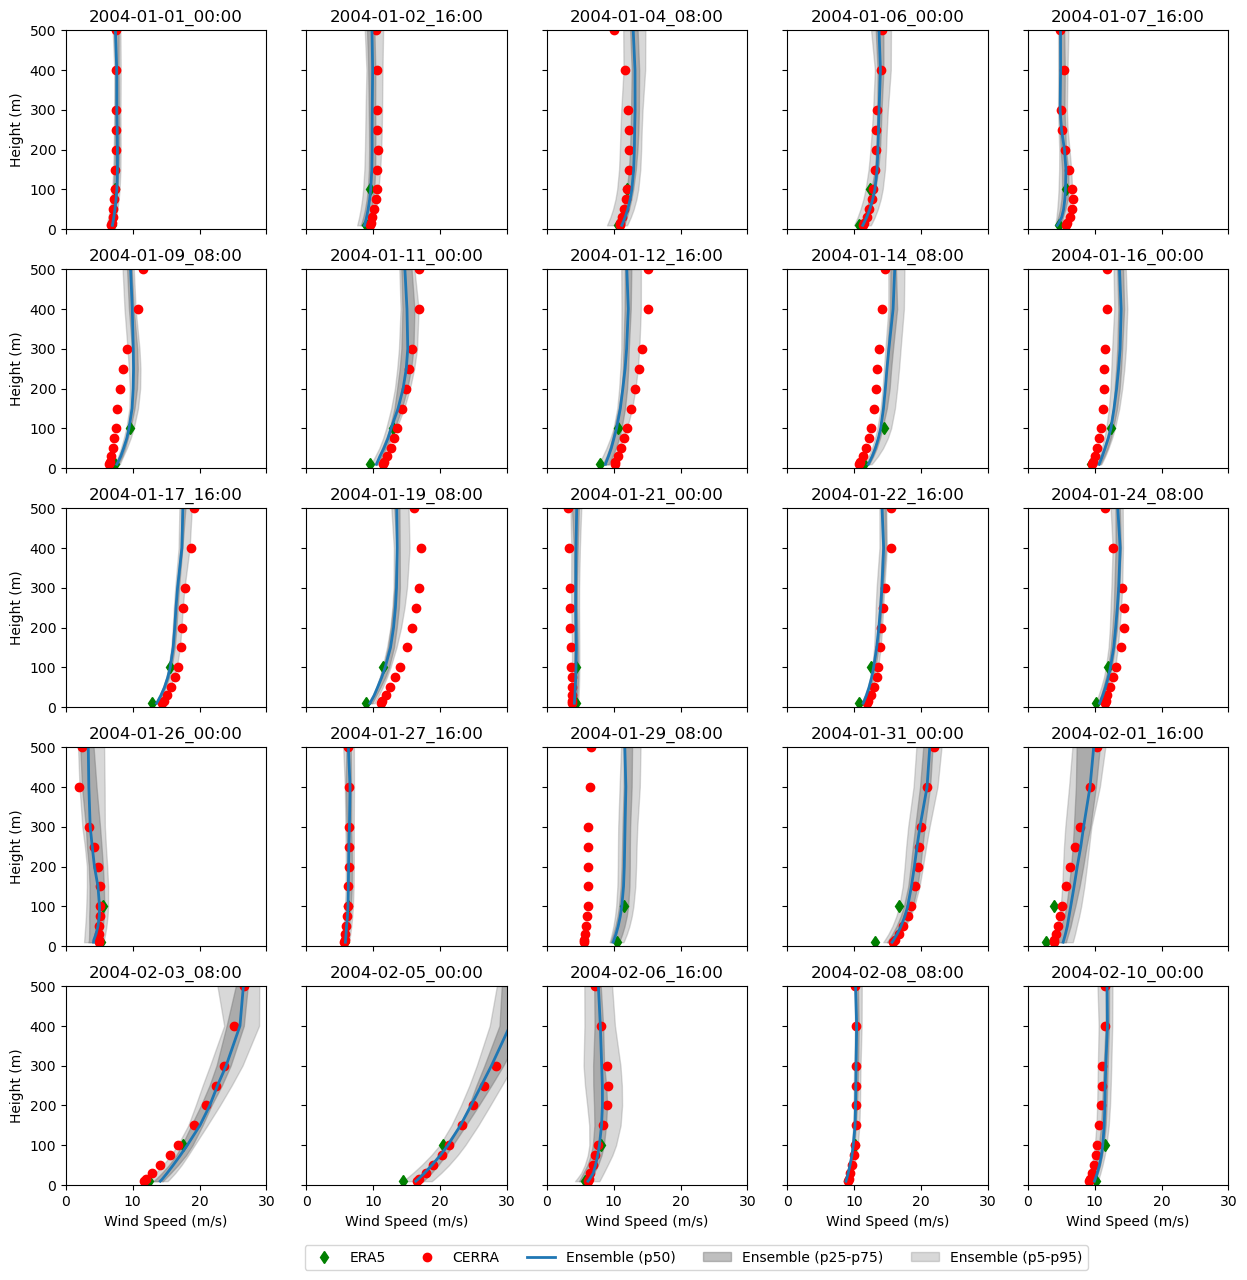

In [33]:
ChSh_Coeff = xr.open_dataset('data/Chebyshev_Coefficnents.nc')
colors = ['blue', 'green', 'purple']
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)

for i in range(0, 1000, 40):
    row = i // 200
    col = (i // 40) % 5

    
    # plot the ERA5 10m and 100m wind speeds
    ERA5_ws = X_test[i,0:2]
    axs[row, col].plot(ERA5_ws, [10.0,100.0], 'dg', markerfacecolor='g', label='ERA5')
    

    # Calculate observed profile
    M_true = WindProfile(Z, Y_test[i, :])
    axs[row, col].plot(M_true, Z, 'or', markerfacecolor='r', label='CERRA')

    # Initialize arrays to store ensemble predictions
    ensemble_predictions = np.zeros((10, len(Z)))

    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'trained_models/models_{experiment}th_set/Ens_{Ens}'

        # Load normalizer
        min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

        # Load model
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test[i:i+1,:]))
        Mp = WindProfile(Z, Y_pred[0, :])
        # Store ensemble predictions
        ensemble_predictions[j, :] = Mp

    # Calculate percentiles
    median_profile = np.median(ensemble_predictions, axis=0)
    p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
    p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
    p5_profile = np.percentile(ensemble_predictions, 5, axis=0)
    p95_profile = np.percentile(ensemble_predictions, 95, axis=0)

    # Plot median
    axs[row, col].plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')

    # Plot shaded regions
    axs[row, col].fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
    axs[row, col].fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p5-p95)')

    axs[row, col].set_xlim([0, 30])
    axs[row, col].set_ylim([0, 500])
    axs[row, col].set_title(f'Profile {i}')
    title = f'{pd.to_datetime(ChSh_Coeff.time.sel(time=slice(*test_dates_range,input_times_freq)).isel(time=i).data).strftime("%Y-%m-%d_%H:%M")}'
    axs[row, col].set_title(title)
    #if row == 0 and col == 0:
        #axs[row, col].legend()

# Set common labels
for ax in axs.flat:
    ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
    ax.label_outer()

# Place a common legend at the bottom
plt.legend(bbox_to_anchor=(0.3, -0.3), borderaxespad=0.,ncol=5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
#plt.savefig(f'{experiment}th_set_Ens_wind_profiles_Tabnet_test.png')

### Making wind profile video
- Each plot correspond to 24 hours of a day (for ERA5 inputs) or 8 hours of a day and three days (for CERRA inputs)

In [33]:
ChSh_Coeff = xr.open_dataset('data/Chebyshev_Coefficnents.nc')
TARGET_DIR = f'Wind_profiles_movie/{experiment}'
os.system(f'mkdir -p {TARGET_DIR}')
def profle_plotter(k,rows,cols):
    start = time.time()
    num_subplots = rows*cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5), sharex=True, sharey=True)
    for i in range(k,k+num_subplots):
        row = (i-k) // cols
        col = i % cols
        
        # plot the ERA5 10m and 100m wind speeds
        ERA5_ws = X_test[i,0:2]
        axs[row, col].plot(ERA5_ws, [10.0,100.0], 'dg', markerfacecolor='g', label='ERA5')
        
        # Calculate observed profile
        M_true = WindProfile(Z, Y_test[i, :])
        axs[row, col].plot(M_true, Z, 'or', markerfacecolor='r', label='CERRA')
    
        # Initialize arrays to store ensemble predictions
        ensemble_predictions = np.zeros((10, len(Z)))
    
        for j, Ens in enumerate(np.arange(10)):
            OUTPUT_DIR = f'models_{experiment}th_set/Ens_{Ens}'
    
            # Load normalizer
            min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')
    
            # Load model
            fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
            with open(fSTR, "rb") as f:
                tabReg = pickle.load(f)
                Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X_test[i:i+1,:]))
            Mp = WindProfile(Z, Y_pred[0, :])
            # Store ensemble predictions
            ensemble_predictions[j, :] = Mp
    
        # Calculate percentiles
        median_profile = np.median(ensemble_predictions, axis=0)
        p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
        p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
        p5_profile = np.percentile(ensemble_predictions, 10, axis=0)
        p95_profile = np.percentile(ensemble_predictions, 90, axis=0)
    
        # Plot median
        axs[row, col].plot(median_profile, Z, linestyle='-', linewidth=2, label='Ensemble (p50)')
    
        # Plot shaded regions
        axs[row, col].fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')
        axs[row, col].fill_betweenx(Z, p5_profile, p95_profile, color='gray', alpha=0.3, label='Ensemble (p10-p90)')
    
        axs[row, col].set_xlim([0, 35])
        axs[row, col].set_ylim([0, 500])
        title = pd.to_datetime(ChSh_Coeff.time.sel(time=slice(*test_dates_range,input_times_freq)).isel(time=i).data).strftime('%Y-%m-%d_%H:%M')
        axs[row, col].set_title(title)
        print(title)
        #if row == 0 and col == 0:
            #axs[row, col].legend()

    # Set common labels
    for ax in axs.flat:
        ax.set(xlabel='Wind Speed (m/s)', ylabel='Height (m)')
        ax.label_outer()
    
    # Place a common legend at the bottom
    plt.legend(bbox_to_anchor=(0.3, -0.3), borderaxespad=0.,ncol=5)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 1])
    
    # Show the plot
    file_name = f'{pd.to_datetime(ChSh_Coeff.time.sel(time=slice(*test_dates_range,input_times_freq)).isel(time=k).data).strftime("%Y-%m-%d_%H:%M")}'
    plt.savefig(f'{TARGET_DIR}/{file_name}.png')
    plt.close()
    end = time.time()
    print(f'Elapsed time {end-start}s for saving {file_name}')

In [ ]:
ChSh_Coeff = xr.open_dataset('data/Chebyshev_Coefficnents.nc')
rows = 6
cols = 4
num_subplots = rows*cols
k = 0
while k < len(X_test):
    profle_plotter(k,rows,cols)
    k += num_subplots  

## Plotting time-series wind peed

In [75]:
CERRA_ds = xr.open_mfdataset('data/CERRA_height_level/*.nc',
                       combine='nested',
                       concat_dim='time')
ERA5 = xr.open_dataset('data/ERA5.nc')

In [119]:
obs = 0
def timeseries_plotter(gs,dates_range,xlabel=None,legend=None):
    ax = fig.add_subplot(gs)
    ax.plot(ERA5['100ws'].sel(time=slice(*dates_range),location=obs),label='ERA5')
    ax.plot(CERRA_ds.data.sel(time=slice(*dates_range),obs = obs,heightAboveGround=100.0),label='CERRA')
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    if legend:
        ax.legend()
    ax.set_ylabel('m/s')
    ax.set_xlim(0,23)
    ax.set_title(f'100m wind speed during {dates_range[0]} to {dates_range[1]}')

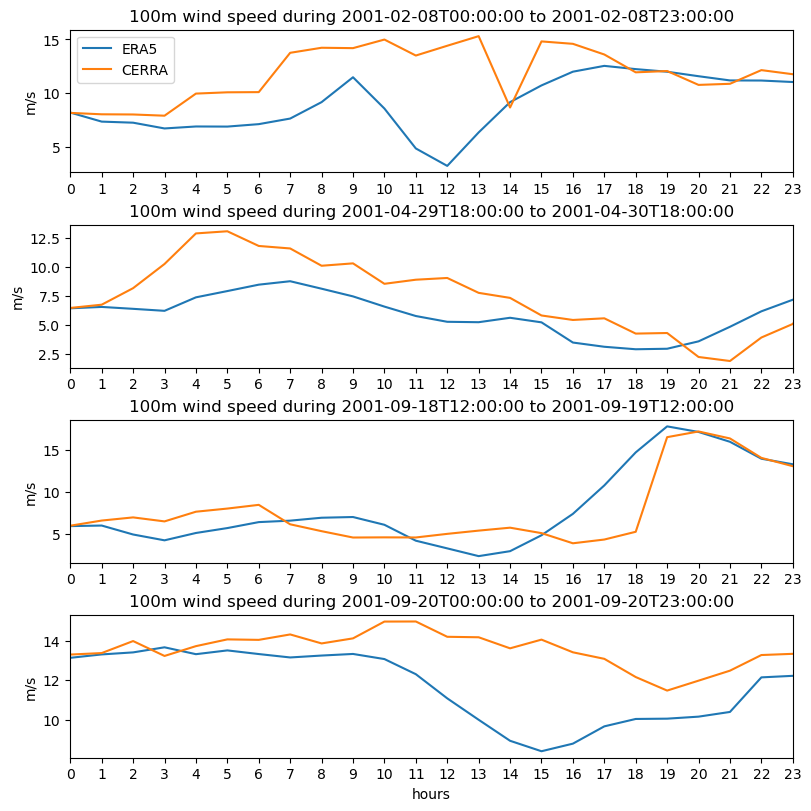

In [131]:
time_ranges = [('2001-02-08T00:00:00','2001-02-08T23:00:00'),
              ('2001-04-29T18:00:00','2001-04-30T18:00:00'),
              ('2001-09-18T12:00:00','2001-09-19T12:00:00'),
              ('2001-09-20T00:00:00','2001-09-20T23:00:00')]
fig = plt.figure(figsize=(8, len(time_ranges)*2), constrained_layout=True)
gs = fig.add_gridspec(len(time_ranges),1)
for i,time_range in enumerate(time_ranges):
    legend=True if i==0 else None
    xlabel='hours' if i==len(time_ranges)-1 else None
    timeseries_plotter(gs[i],time_range,xlabel=xlabel,legend=legend)
plt.savefig('Figures/ERA5-CERRA_100m_wind_timeseries.pdf',dpi=300,bbox_inches='tight',pad_inches=0)

In [169]:
ChSh_Coeff = xr.open_dataset('data/Chebyshev_Coefficnents.nc')
rows = 6
cols = 4
num_subplots = rows*cols
for i,time_range in enumerate(time_ranges):
    k = np.where(ERA5.time.sel(time=slice(*test_dates_range)) == np.datetime64(time_range[0]))[0][0]
    profle_plotter(k,rows,cols)

/tmp/ipykernel_3260379/368531243.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 1, 1])


Elapsed time 64.95961666107178s for saving 2001-02-08_00:00


/tmp/ipykernel_3260379/368531243.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 1, 1])


Elapsed time 27.899574279785156s for saving 2001-04-29_18:00


/tmp/ipykernel_3260379/368531243.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 1, 1])


Elapsed time 28.117775678634644s for saving 2001-09-18_12:00


/tmp/ipykernel_3260379/368531243.py:67: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, 1, 1])


Elapsed time 27.985427379608154s for saving 2001-09-20_00:00


In [54]:
tabnet_param_dfs = []
for experiment in [8,11,12]:
    tabnet_params = pd.DataFrame(columns=['n_d','n_a','n_steps','n_independent','n_shared','gamma'])
    for j, Ens in enumerate(np.arange(10)):
        OUTPUT_DIR = f'trained_models/models_{experiment}th_set/Ens_{Ens}'
        # Load model
        fSTR = f'{OUTPUT_DIR}/TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
        with open(fSTR, "rb") as f:
            tabReg = pickle.load(f)
            tabnet_params.loc[j] = [tabReg.n_d,tabReg.n_a,tabReg.n_steps,tabReg.n_independent,tabReg.n_shared,tabReg.gamma]
    tabnet_param_dfs.append(tabnet_params)